# RENEWABLE ENERGY SECTOR - MOMENTUM ANALYSIS

## DATA / SOURCES

* https://www.eia.gov/opendata/

* https://www.eia.gov/outlooks/aeo/

* https://www.eia.gov/energyexplained/electricity/electricity-in-the-us-generation-capacity-and-sales.php

* https://www.iea.org/reports/renewable-energy-market-update

* https://www.eia.gov/energyexplained/electricity/electricity-in-the-us-generation-capacity-and-sales.php

* https://www.lazard.com/perspective/levelized-cost-of-energy-and-levelized-cost-of-storage-2020/

* https://www.eia.gov/energyexplained/us-energy-facts/

* https://github.com/ranaroussi/yfinance

#### README NOTES

* With the luxury of conveniently accessible energy metrics, widely available for public download across the web, primary features as modeled herein were selected from a merged dataset, indexed by quarterly intervals, containing:
  * EIA
    * Production / Consumption by Sector (2011-2020)
    * Electricity Generation by Sector (2018-2020)
    * Outlook Projections (2021-2050)
  * Polygon - Quarterly Balance Sheets (2011-2019) 
  * Yahoo Finance - Quarterly Balance Sheets (2020-2021)
    * Company Information
    * Market / Trading Data
    * Operating Financials
    * Equity Research Ratings
    * Institutional Shareholders

* Recent, unprecedented volume spikes across many renewable energy companies have drawn greater focus towards general momentum entering the sector, in terms of daily trading volume and capital flow. Sugnificant retail investor capital entering the renewable sector is certainly a factor, though trends in broader energy generation may present further answers as to recent sustained upticks in trading volume across all renewable sectors in the public markets.

* Valuation of each renewable sector alongside one another allows for exploration of alternative or untested potential correlation across the sector, namely throuogh quarterly trading volume or total share price returns over bands of time.

* Employing live API connections allows this model to remain highly dynamic over time. Ticker input flexibility allows for use of API import functionality across any public market industry or sector

* By importing data from EIA - a related, yet dissimilar external source -  analysis as follows aims to explore and seek out otherwise notable correlations across US energy production & consumption.

* EIA's data, as interwoven with quarterly public filings data from renewable energy companies, offers a wide range of prospective variables for visualization; however, wildly diverse unit types (MWh, BTU, $MM, #MM) is likely to require significant scaling or normalization.

* Production & consumption data as presented herein does not immediately suggest a clear connection exists between macro-level energy ouput levels and recent elevated trading volume across the renewable sector.

## LIBRARY IMPORTS

In [ ]:
## LIBRARY IMPORTS ##

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import requests
import json
import time
from google.colab import drive

from scipy import stats as stats
import statistics
import datetime as dt

#!pip install EIA_python
#!pip install yfinance
import eia
import yfinance as yf

In [ ]:
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


## DATA IMPORTS

#### MASTER ROLLUP

In [ ]:
master_rollup = pd.read_csv('/drive/My Drive/Colab Notebooks/project05_data/financials_rollup.csv', index_col = 'reportPeriod')
#master_rollup.info(max_cols=110)

In [ ]:
# final tweaks / feature engineering
master_rollup['Oil_Cons/Prod'] = master_rollup['Petro_Cons'] / master_rollup['Crude_Prod']
master_rollup['Coal_Cons/Prod'] = master_rollup['Coal_Cons'] / master_rollup['Coal_Prod']
master_rollup['Wood_Cons/Prod'] = master_rollup['Wood_Energy_Cons'] / master_rollup['Wood_Energy_Prod']
master_rollup['Nat_Gas_Cons/Prod'] = master_rollup['Natural_Gas_Cons'] / master_rollup['Natural_Gas(dry)_Prod']
master_rollup['Tot_FF_Cons/Prod'] = master_rollup['Tot_FF_Cons'] / master_rollup['Tot_FF_Prod']
master_rollup['Tot_Renew_Cons/Prod'] = master_rollup['Tot_Renew_Cons'] / master_rollup['Tot_Renew_Prod']
master_rollup['Tot_Primary_Cons/Prod'] = master_rollup['Tot_Primary_Cons'] / master_rollup['Tot_Primary_Prod']
master_rollup['Biofuels_Cons/Prod'] =  master_rollup['Biofuels_Cons'] / master_rollup['Biofuels_Prod']
master_rollup['Dollar_Volume_Qtr'] =  master_rollup['totalVolumeQtr'] * master_rollup['avgSharePrice']
master_rollup['Dollar_Volume_Trailing'] =  master_rollup['trailingVolume1yr'] * master_rollup['avgSharePrice']

# column refinement
master_cols = ['Ticker', 'Sector', 'Year', 'Month', 'Quarter', 'assets',
       'cashAndEquivalents', 'shareholdersEquity', 'totalLiabilities',
       'propertyPlantEquipmentNet', 'shares', 'tangibleAssetValue',
        'Geothermal_Energy_Cons/Prod', 'Hydroelectric_Power_Cons/Prod',
        'Solar/PV_Energy_Cons/Prod', 'Oil_Cons/Prod', 'Coal_Cons/Prod', 'Wood_Cons/Prod',
        'Nat_Gas_Cons/Prod', 'Tot_FF_Cons/Prod', 'Tot_Renew_Cons/Prod', 'Wind_Energy_Cons/Prod',
        'Nucler_Power_Cons/Prod', 'Tot_Primary_Cons/Prod', 'Elec_Gen_Coal', 'Elec_Gen_Nat_Gas',
        'Elec_Gen_Petroleum', 'Elec_Gen_Nuclear', 'Elec_Gen_Solar',
       'Elec_Gen_Wind', 'Elec_Gen_Hydro', 'Elec_Gen_Other', 'Elec_FF_Ttl',
       'Elec_Renew_Ttl', 'Elec_FF_Pct', 'Elec_Renew_Pct', 'totalVolumeQtr',
       'trailingVolume1yr', 'avgSharePrice', 'totalReturnPctYr', 'totalReturnPct9mo',
       'totalReturnPct6mo', 'totalReturnPct3mo', 'Dollar_Volume_Qtr', 'Dollar_Volume_Trailing']

master_cols = master_rollup[master_cols]

#### POLYGON FINANCIALS

In [ ]:
all_financials = pd.read_csv('/drive/My Drive/Colab Notebooks/project05_data/hist_bs.csv', infer_datetime_format = True, index_col = 'reportPeriod')

#### YAHOO FINANCE DATA

In [ ]:
holders_data = pd.read_csv('/drive/My Drive/Colab Notebooks/project05_data/yf_holders_data.csv', infer_datetime_format = True, index_col = 'ticker')
recs_data = pd.read_csv('/drive/My Drive/Colab Notebooks/project05_data/yf_bs_data.csv', infer_datetime_format = True, index_col = 'ticker')
all_tickers_10yr = pd.read_csv('/drive/My Drive/Colab Notebooks/project05_data/yf_all_tickers_10yr.csv', infer_datetime_format = True, index_col = 0)
all_tickers_5yr = pd.read_csv('/drive/My Drive/Colab Notebooks/project05_data/yf_all_tickers_5yr.csv', infer_datetime_format = True, index_col = 0)

#yf_hist_bs = pd.read_csv('/drive/My Drive/Colab Notebooks/project05_data/yf_hist_bs.csv', infer_datetime_format = True, index_col = 'longName')
#yf_info = pd.read_csv('/drive/My Drive/Colab Notebooks/project05_data/yf_info.csv', infer_datetime_format = True, index_col = 'longName')

### EIA IMPORTS

In [ ]:
eia_data = pd.read_csv('/drive/My Drive/Colab Notebooks/project05_data/eia_data.csv', index_col = 'Date')
eia_electric = pd.read_csv('/drive/My Drive/Colab Notebooks/project05_data/eia_electric.csv', index_col = 'Date')
eia_outlook = pd.read_csv('/drive/My Drive/Colab Notebooks/project05_data/eia_outlook.csv', index_col = 'Date')

# VISUALIZATIONS

* Assignment of feature groupings allows for detailed, granular charting of tickers and sectors across data types within our data set:
  * label_cols = index / time coding 
  * financial_cols = balance sheet financials
  * trading_cols = trading / market data
  * return_cols = total return over time (share price)
  * prod_cons_cols = energy consumption / production by sector (historical)
  * electric_cols = electricity generation by sector (historical)

In [ ]:
## CHART FEATURE VARIABLES ASSIGNMENT

label_cols = ['Ticker', 'Sector', 'Year', 'Month', 'Quarter']

financial_cols = ['assets', 'cashAndEquivalents', 'shareholdersEquity', 'totalLiabilities',
                  'propertyPlantEquipmentNet', 'shares', 'tangibleAssetValue']

trading_cols = ['totalVolumeQtr','trailingVolume1yr', 
                'avgSharePrice', 'totalReturnPctYr', 'totalReturnPct9mo', 'totalReturnPct6mo', 'totalReturnPct3mo',
                'Dollar_Volume_Qtr', 'Dollar_Volume_Trailing']

#vol_cols = ['totalVolumeQtr','trailingVolume1yr', 'trailingVolume9mo', 'trailingVolume6mo']

return_cols = ['avgSharePrice', 'totalReturnPctYr', 'totalReturnPct9mo', 'totalReturnPct6mo', 'totalReturnPct3mo']

prod_cons_cols = ['Geothermal_Energy_Cons/Prod', 'Hydroelectric_Power_Cons/Prod',
                  'Solar/PV_Energy_Cons/Prod', 'Oil_Cons/Prod', 'Coal_Cons/Prod', 'Wood_Cons/Prod',
                  'Nat_Gas_Cons/Prod', 'Tot_FF_Cons/Prod', 'Tot_Renew_Cons/Prod', 'Wind_Energy_Cons/Prod',
                  'Nucler_Power_Cons/Prod', 'Tot_Primary_Cons/Prod']
        
electric_cols = ['Elec_Gen_Coal', 'Elec_Gen_Nat_Gas', 'Elec_Gen_Petroleum', 'Elec_Gen_Nuclear', 'Elec_Gen_Solar',
                 'Elec_Gen_Wind', 'Elec_Gen_Hydro', 'Elec_Gen_Other', 'Elec_FF_Ttl', 'Elec_Renew_Ttl', 'Elec_FF_Pct', 'Elec_Renew_Pct']

* Generating Pairplots below to assess correlations, patterns, trends, linearity, or other interrelated features across our external data sets
  * Seeking visible relationships to extract for further evaluation, of which the strongest relationships will ultimately be passed through models
  * 1-Year trailing volume pairplots appear to hold heigher weight correlation-wise vs. standard quarterly volume
  * It appears a number of outliers are 'smoothed out' by engineering a feature for rolling volume, enhancing feature relationships


<Figure size 1080x1080 with 0 Axes>

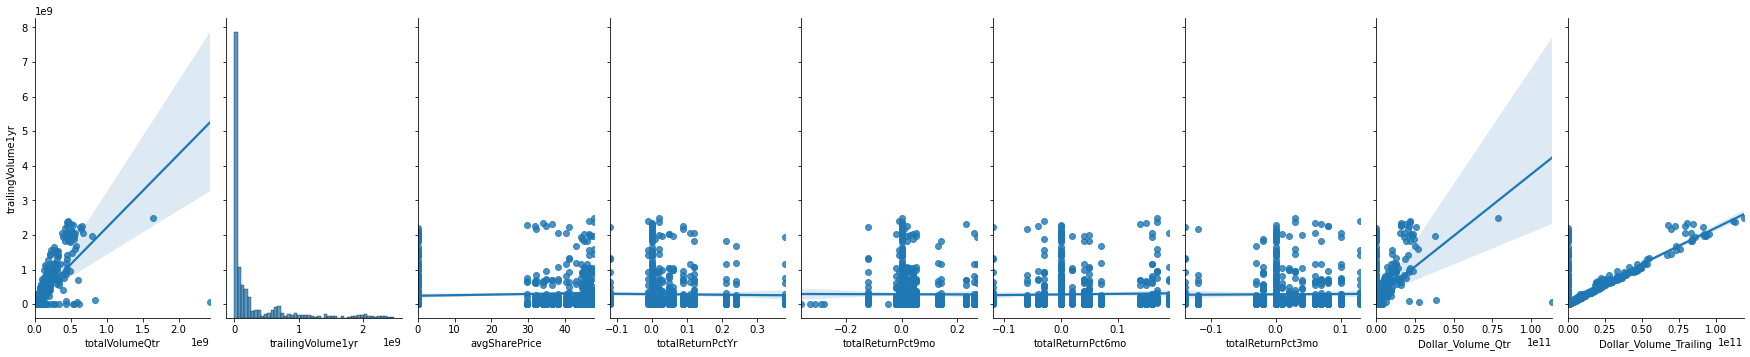

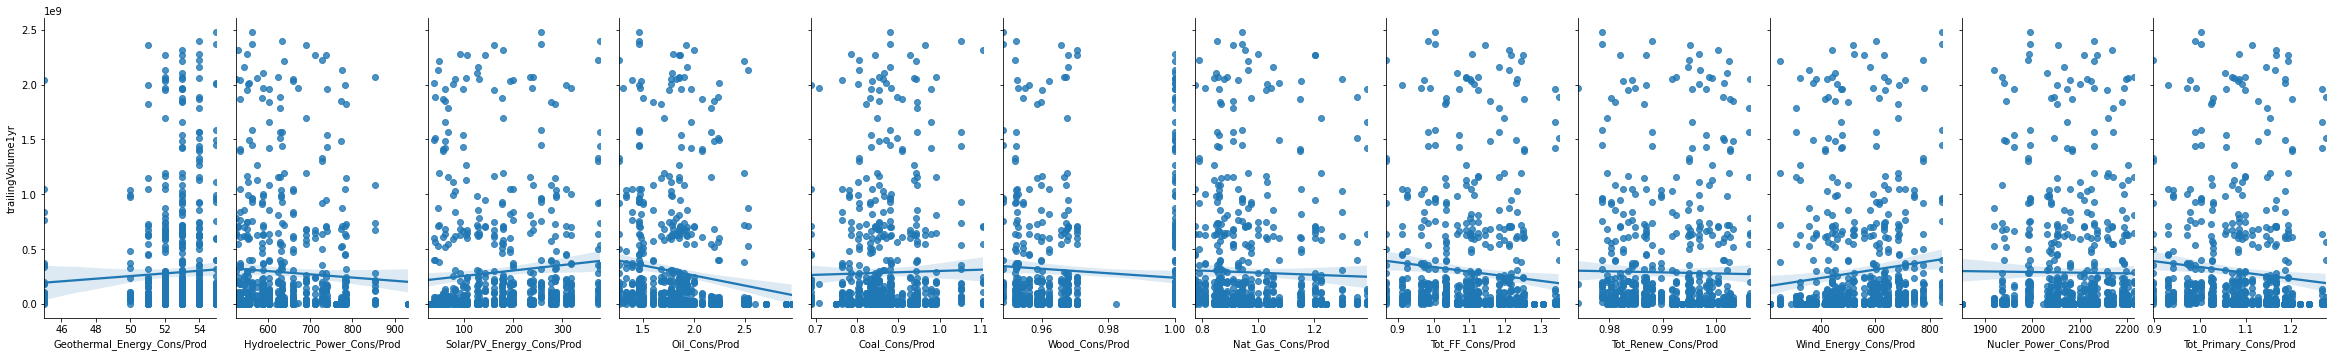

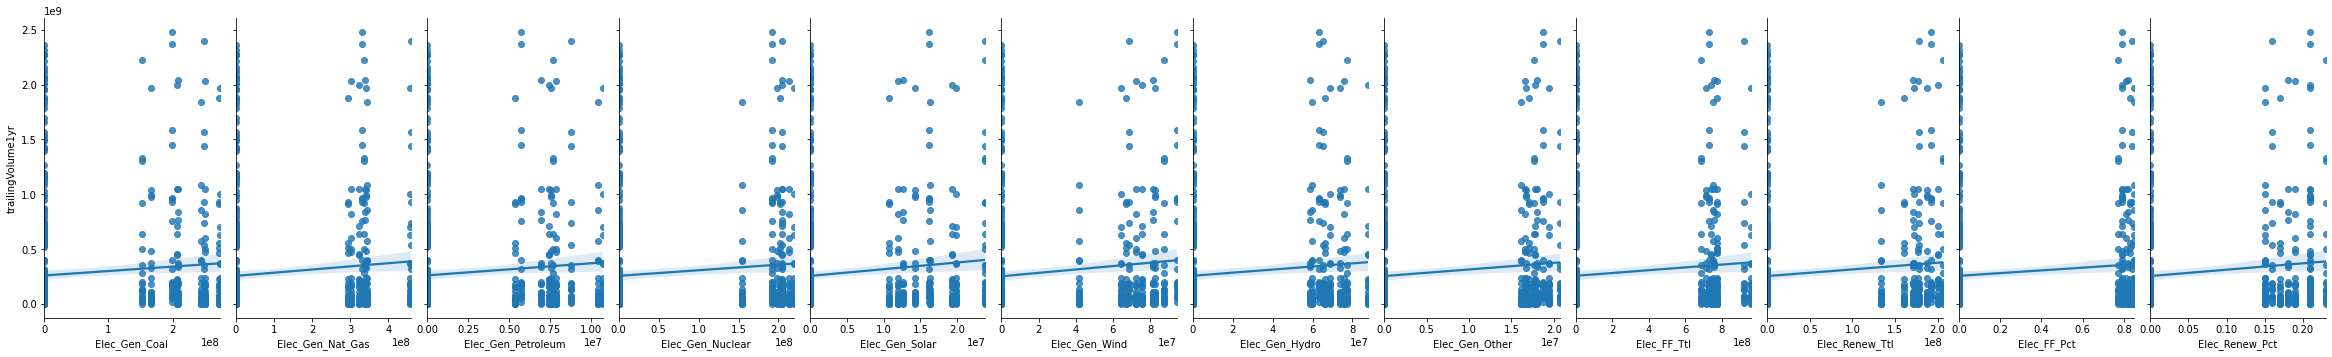

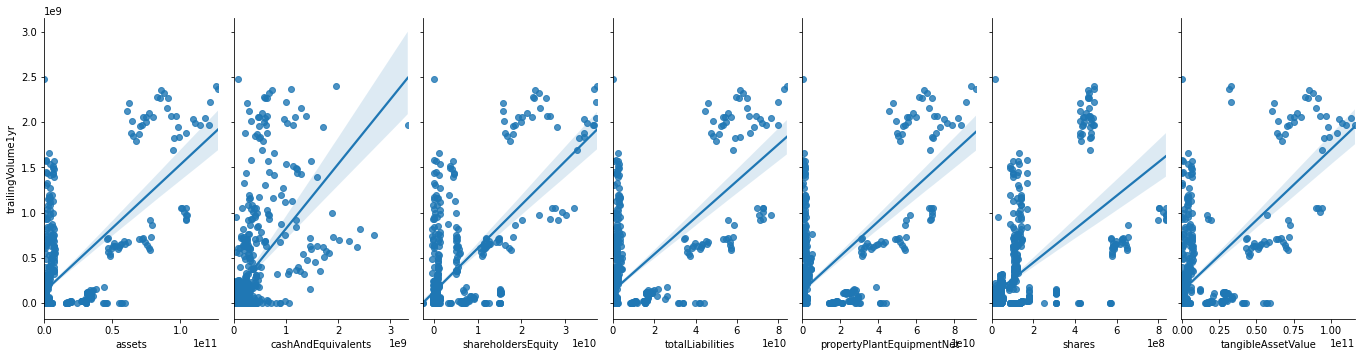

In [ ]:
# explore / interpret pairplot visualization
plt.figure(figsize = (15,15))
sns.pairplot(master_cols, x_vars=trading_cols, y_vars='trailingVolume1yr', kind='reg', height=5, aspect=.55, palette = 'mako')
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/pairplot_trailingVolume1yr_1.png')
sns.pairplot(master_cols, x_vars=prod_cons_cols, y_vars='trailingVolume1yr', kind='reg', height=5, aspect=.55, palette = 'mako')
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/pairplot_trailingVolume1yr_2.png')
sns.pairplot(master_cols, x_vars=electric_cols, y_vars='trailingVolume1yr', kind='reg', height=5, aspect=.55, palette = 'mako')
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/pairplot_trailingVolume1yr_3.png')
sns.pairplot(master_cols, x_vars=financial_cols, y_vars='trailingVolume1yr', kind='reg', height=5, aspect=.55, palette = 'mako')
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/pairplot_trailingVolume1yr_4.png');

<Figure size 1080x1080 with 0 Axes>

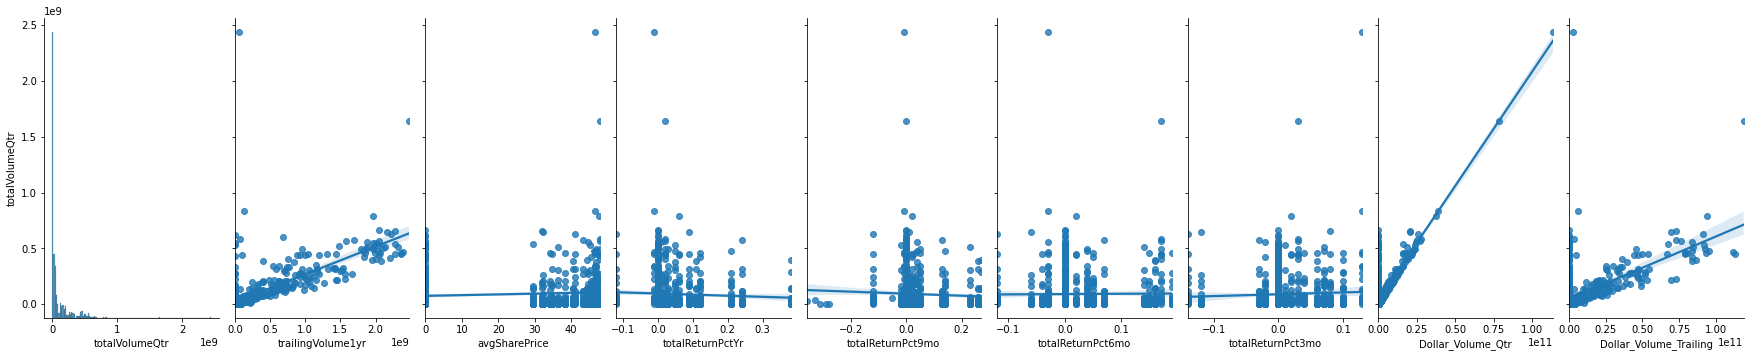

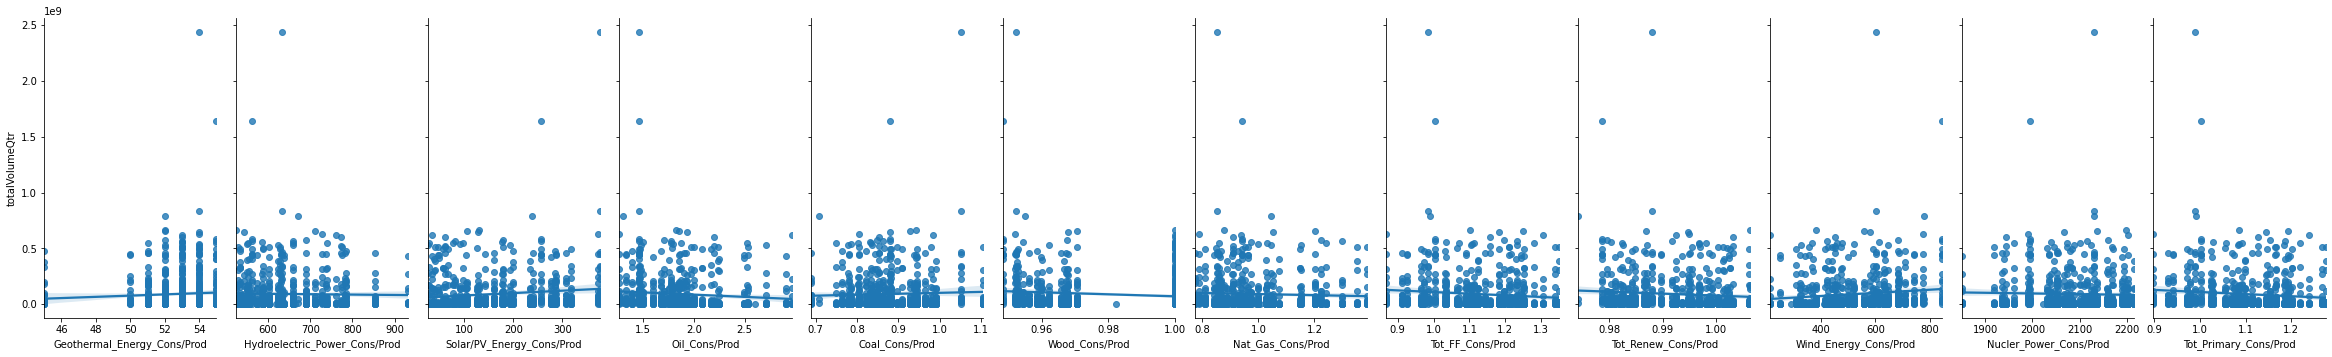

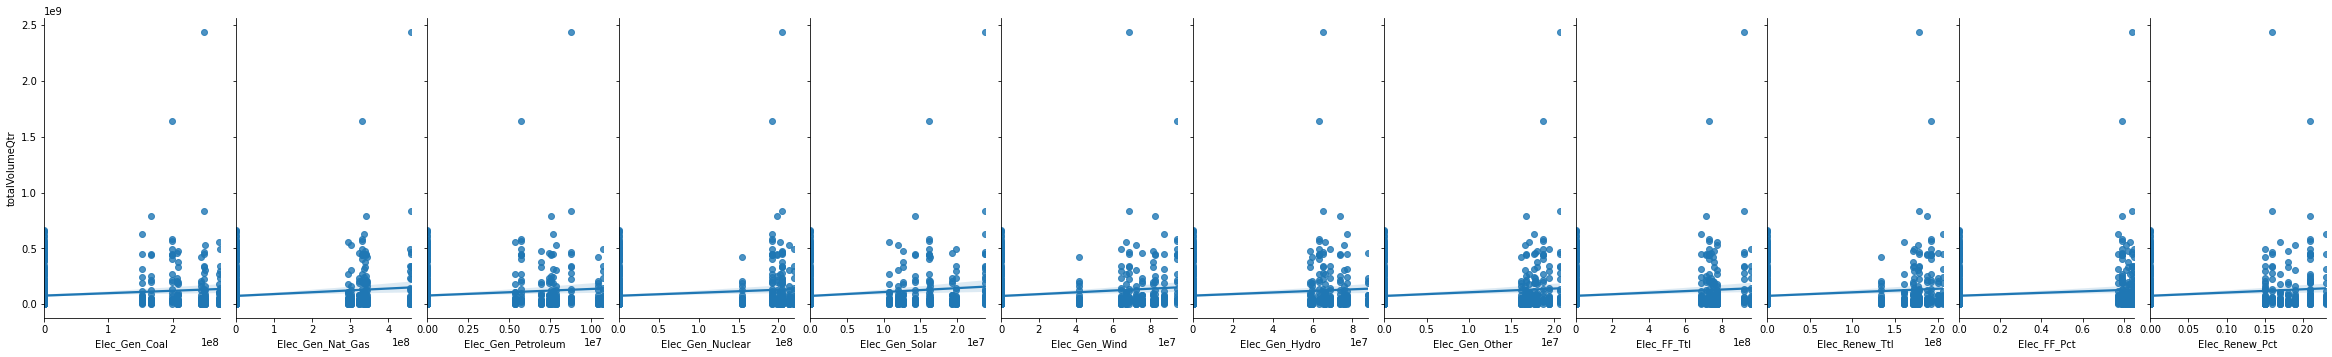

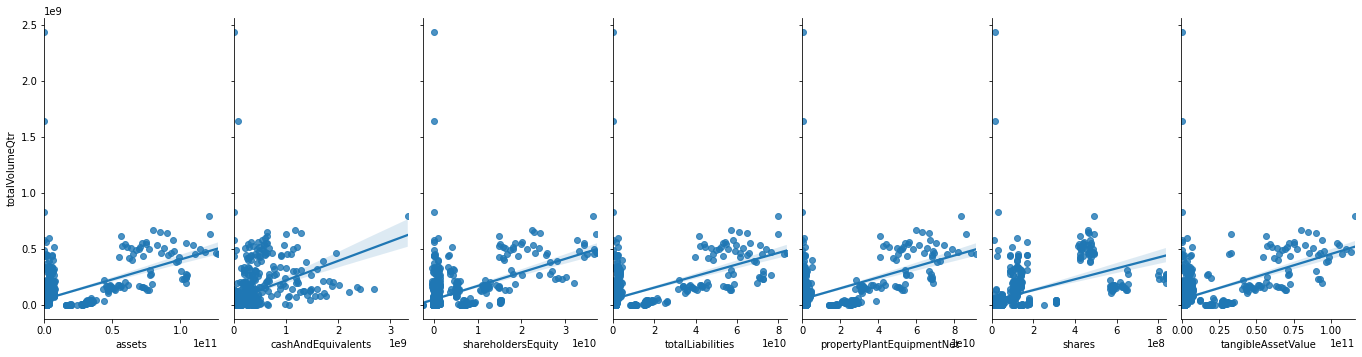

In [ ]:
# explore / interpret pairplot visualization
plt.figure(figsize = (15,15))
sns.pairplot(master_cols, x_vars=trading_cols, y_vars='totalVolumeQtr', kind='reg', height=5, aspect=.55, palette = 'mako')
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/pairplot_quarterly_vol_1.png')
sns.pairplot(master_cols, x_vars=prod_cons_cols, y_vars='totalVolumeQtr', kind='reg', height=5, aspect=.55, palette = 'mako')
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/pairplot_quarterly_vol_2.png')
sns.pairplot(master_cols, x_vars=electric_cols, y_vars='totalVolumeQtr', kind='reg', height=5, aspect=.55, palette = 'mako')
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/pairplot_quarterly_vol_3.png')
sns.pairplot(master_cols, x_vars=financial_cols, y_vars='totalVolumeQtr', kind='reg', height=5, aspect=.55, palette = 'mako')
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/pairplot_quarterly_vol_4.png')

* Generating Boxplots below to assess overall data distribution and identify potential outliers
  * Evaluating by both Sector and Ticker groupings, over differentiated timeframes, presents affirmative data indicating a clearly developing trend in elevated trading activity across all renewable sectors
  * Grouping tickers by renewable sector seems to result in more evident trends, as opposed to viewing volume by individual tickers
  * Sector groupings have experienced similar upticks in volume across the observed timeframe, though to varying magnitudes
  * Trading Volume appears to hold slight seasonality during Q4, independent of year; this indicates greater investor activity

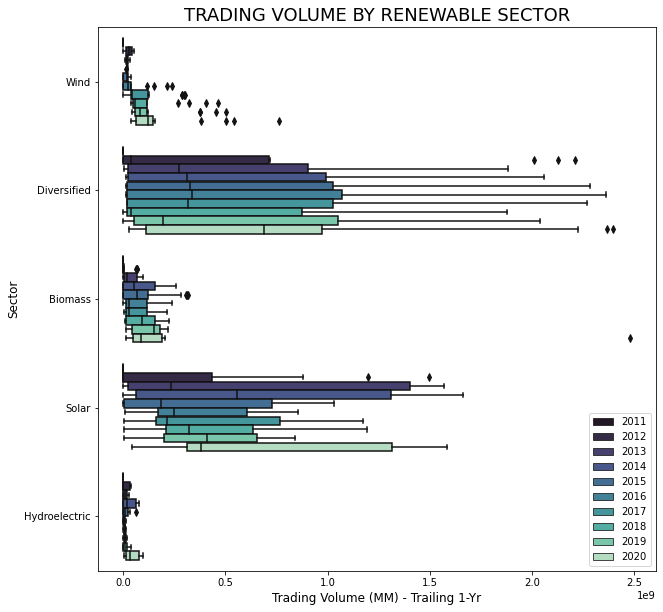

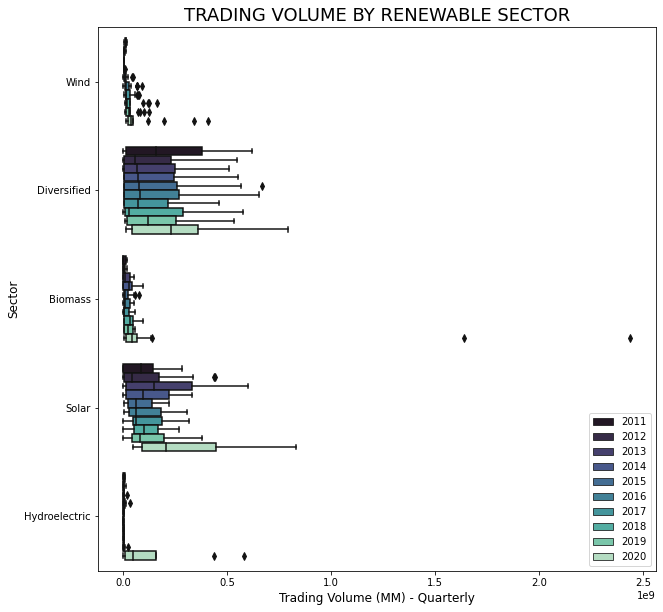

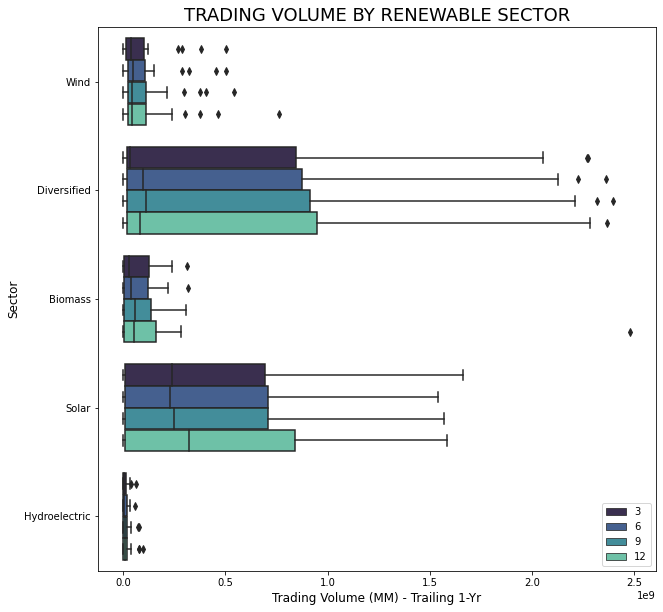

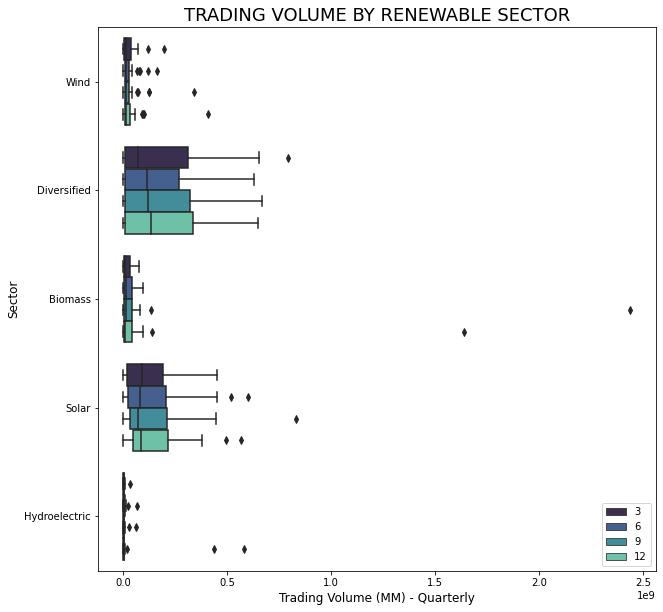

In [ ]:
### TRADING VOLUME BY SECTOR - Trailing 1Yr  - by year
plt.figure(figsize = (10, 10))
sns.boxplot(data = master_cols, x = 'trailingVolume1yr', y = 'Sector', hue = "Year", palette = "mako")
plt.title('TRADING VOLUME BY RENEWABLE SECTOR', fontsize = 18)
plt.xlabel('Trading Volume (MM) - Trailing 1-Yr', fontsize = 12)
plt.ylabel('Sector', fontsize = 12)
plt.legend(loc = "lower right")
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/sector_trailing1yr_vol_yr.png')

### TRADING VOLUME BY SECTOR - Quarterly - by year 
plt.figure(figsize = (10, 10))
sns.boxplot(data = master_cols, x = 'totalVolumeQtr', y = 'Sector', hue = "Year", palette = "mako")
plt.title('TRADING VOLUME BY RENEWABLE SECTOR', fontsize = 18)
plt.xlabel('Trading Volume (MM) - Quarterly', fontsize = 12)
plt.ylabel('Sector', fontsize = 12)
plt.legend(loc = "lower right")
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/sector_quarterly_vol_yr.png')

### TRADING VOLUME BY SECTOR - Trailing 1Yr - by quarter
plt.figure(figsize = (10, 10))
sns.boxplot(data = master_cols, x = 'trailingVolume1yr', y = 'Sector', hue = "Month", palette = "mako")
plt.title('TRADING VOLUME BY RENEWABLE SECTOR', fontsize = 18)
plt.xlabel('Trading Volume (MM) - Trailing 1-Yr', fontsize = 12)
plt.ylabel('Sector', fontsize = 12)
plt.legend(loc = "lower right")
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/sector_trailing1yr_vol_qtr.png')

### TRADING VOLUME BY SECTOR - Quarterly - by quarter
plt.figure(figsize = (10, 10))
sns.boxplot(data = master_cols, x = 'totalVolumeQtr', y = 'Sector', hue = "Month", palette = "mako")
plt.title('TRADING VOLUME BY RENEWABLE SECTOR', fontsize = 18)
plt.xlabel('Trading Volume (MM) - Quarterly', fontsize = 12)
plt.ylabel('Sector', fontsize = 12)
plt.legend(loc = "lower right")
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/sector_quarterly_vol_qtr.png');

No handles with labels found to put in legend.
No handles with labels found to put in legend.


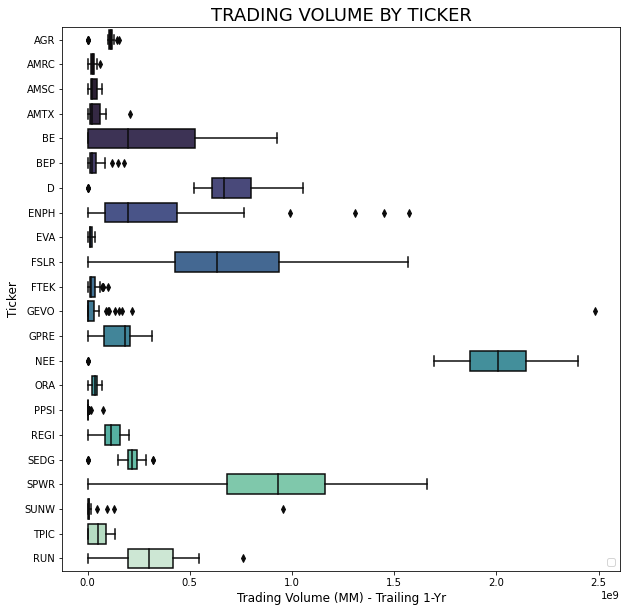

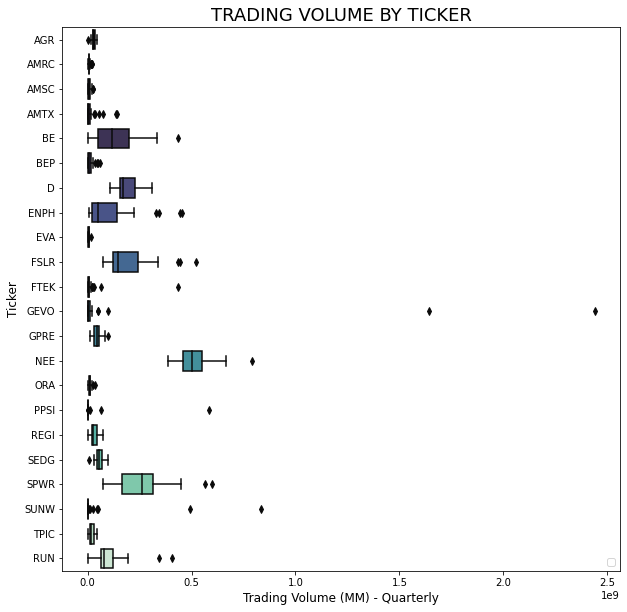

In [ ]:
### TRADING VOLUME BY TICKER - Trailing 1Yr - by ticker
plt.figure(figsize = (10, 10))
sns.boxplot(data = master_cols, x = 'trailingVolume1yr', y = 'Ticker', palette = "mako")
plt.title('TRADING VOLUME BY TICKER', fontsize = 18)
plt.xlabel('Trading Volume (MM) - Trailing 1-Yr', fontsize = 12)
plt.ylabel('Ticker', fontsize = 12)
plt.legend(loc = "lower right")
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/ticker_trailing1yr_vol.png')

### TRADING VOLUME BY TICKER - Trailing 1Yr - by ticker
plt.figure(figsize = (10, 10))
sns.boxplot(data = master_cols, x = 'totalVolumeQtr', y = 'Ticker', palette = "mako")
plt.title('TRADING VOLUME BY TICKER', fontsize = 18)
plt.xlabel('Trading Volume (MM) - Quarterly', fontsize = 12)
plt.ylabel('Ticker', fontsize = 12)
plt.legend(loc = "lower right")
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/ticker_quarterly_vol.png');

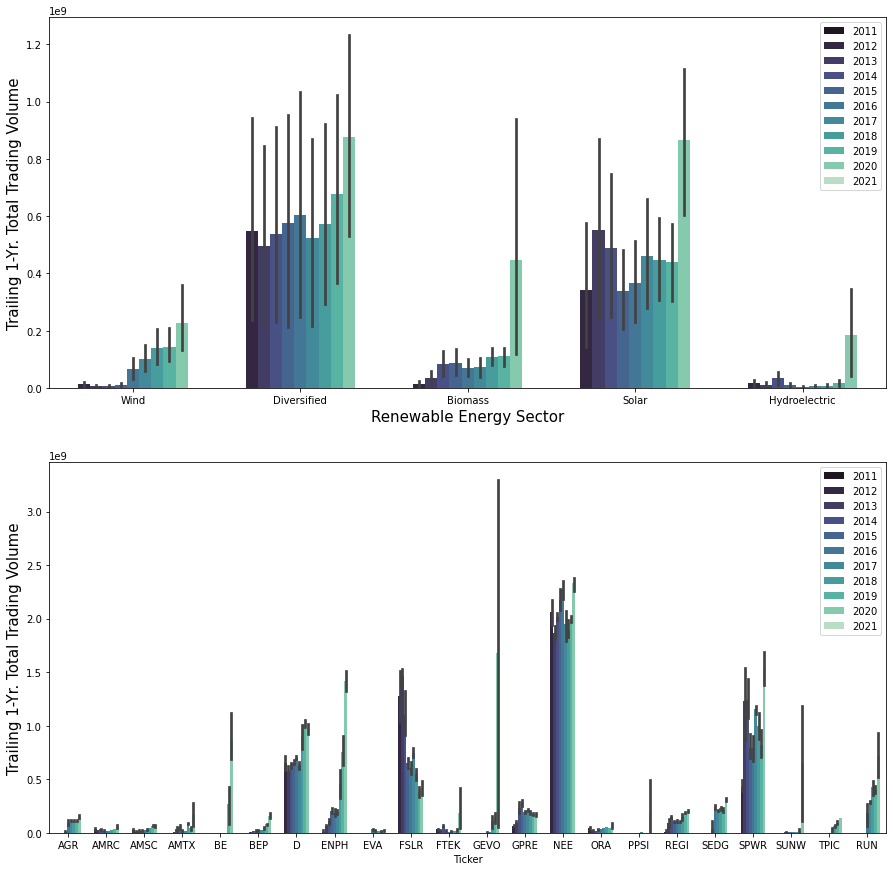

In [ ]:
plt.figure(figsize=(15,15))

ax1 = plt.subplot(211)
sns.barplot(data=master_cols, x="Sector", y="propertyPlantEquipmentNet", hue = "Year", palette = "mako")
plt.xlabel('Renewable Energy Sector', fontsize = 15)
plt.ylabel('Trailing 1-Yr. Total Trading Volume', fontsize = 15)
plt.legend(loc = "best")

ax2 = plt.subplot(212)
sns.barplot(data=master_cols, x="Ticker", y="trailingVolume1yr", hue = "Year", palette = "mako")
plt.ylabel('Trailing 1-Yr. Total Trading Volume', fontsize = 15)
plt.legend(loc = "best");

* Generating Lineplots below to assess market performance over time
  * Bucketing tickers by sector allows for interpretation of 'consensus' sector performance over time (by volume and/or share price)
  * While trailing 1-year data as presented appears 'smoother' than its corrolary quarterly data (which appears somewhat jagged over time), the range of values for each sector are of far wider magnitude than as viewed on a quarterly basis

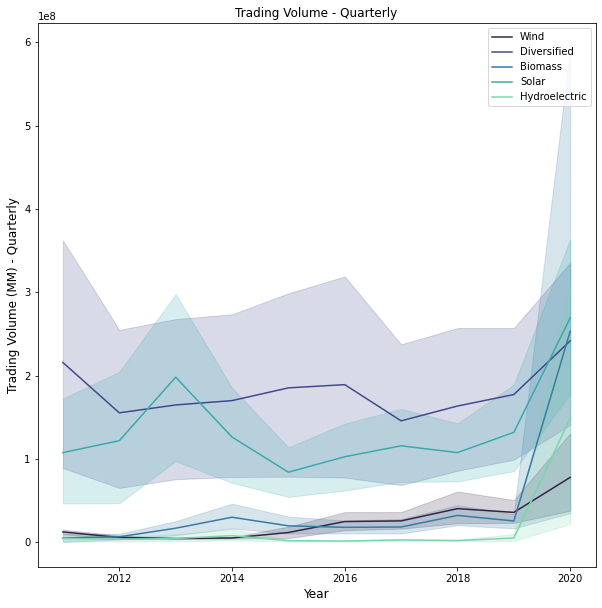

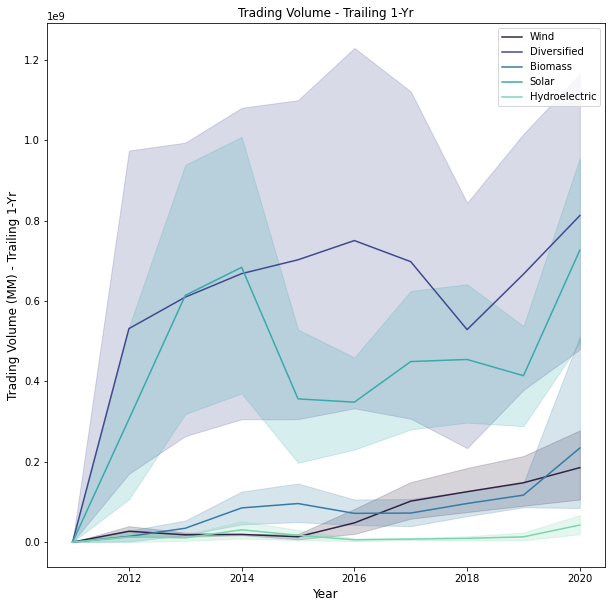

In [ ]:
plt.figure(figsize = (10, 10))
sns.lineplot(data = master_cols, x = 'Year', y = 'totalVolumeQtr', hue = 'Sector', palette = "mako", legend = "full")
plt.title('Trading Volume - Quarterly', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Trading Volume (MM) - Quarterly', fontsize = 12)
plt.legend(loc = "best")
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/line_sector_quarterly_vol.png')

plt.figure(figsize = (10, 10))
sns.lineplot(data = master_cols, x = 'Year', y = 'trailingVolume1yr', hue = 'Sector', palette = "mako", legend = "full")
plt.title('Trading Volume - Trailing 1-Yr', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Trading Volume (MM) - Trailing 1-Yr', fontsize = 12)
plt.legend(loc = "best")
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/line_sector_trailing_vol.png');

* Engineered variable 'Dollar Volume', capturing average share price / trading volume to more precisely estimate or infer renewable sector capital flows
  * Greater positive trends are exhibited with the engineered 'Dollar Volume' than prior visualizations of simple trading volume
  * Extreme volatility as evidenced by spiky, jagged performance over time
  * Despite this volatility, 'Dollar Volume' may still be worthy of consideration as a potential 'predictable' variable for future analysis

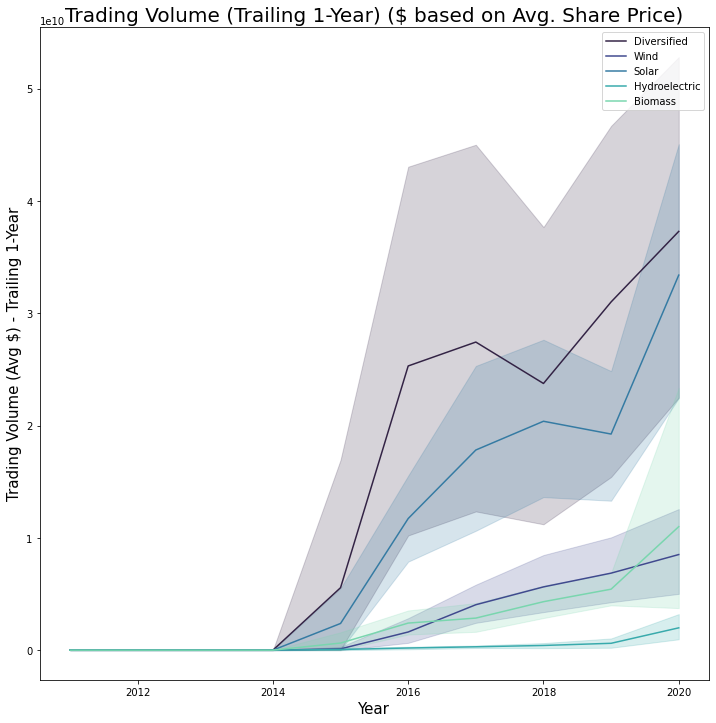

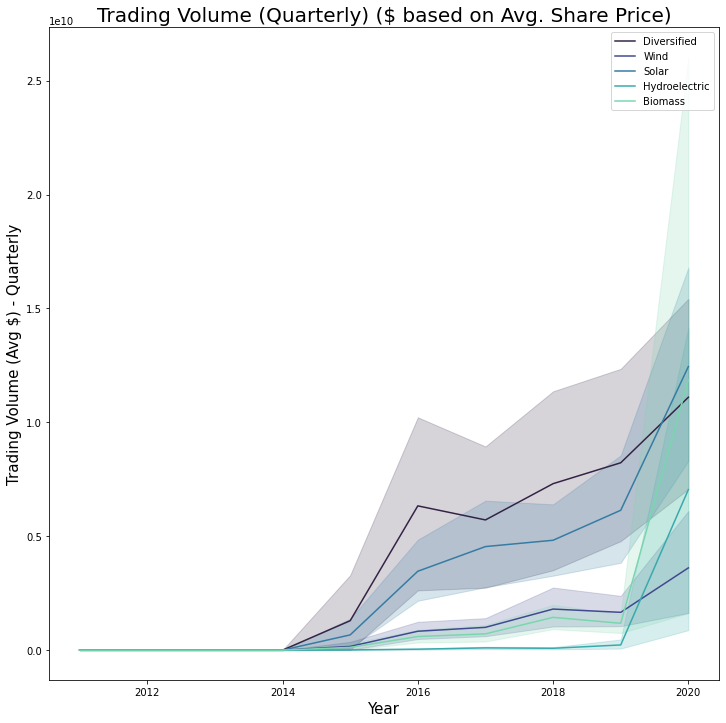

In [ ]:
plt.figure(figsize=(12,12))
sns.lineplot(data = master_cols, x="Year", y="Dollar_Volume_Trailing", hue="Sector", palette="mako")
plt.title('Trading Volume (Trailing 1-Year) ($ based on Avg. Share Price)', fontsize = 20)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Trading Volume (Avg $) - Trailing 1-Year', fontsize = 15)
plt.legend(loc = "best")
#plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/dol_vol_trailing.png');

plt.figure(figsize=(12,12))
sns.lineplot(data = master_cols, x="Year", y="Dollar_Volume_Qtr", hue="Sector", palette="mako")
plt.title('Trading Volume (Quarterly) ($ based on Avg. Share Price)', fontsize = 20)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Trading Volume (Avg $) - Quarterly', fontsize = 15)
plt.legend(loc = "best")
#plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/dol_vol_qtr.png');

* Generating Barplots below to gain further detail around company growth over time, through variables of PP&E, Shareholder Equity, and Cash & Equivalents, as reported publicly on quarterly balance sheets
  * Clear increases over time for all three observed variables suggest recent spikes in trading volume may have contributed to underlying operational growth at the company-level
  * Significant increases in reported PP&E further bolster trends as observed within EIA data, relating to renewable energy production as a percentage of total energy production
  

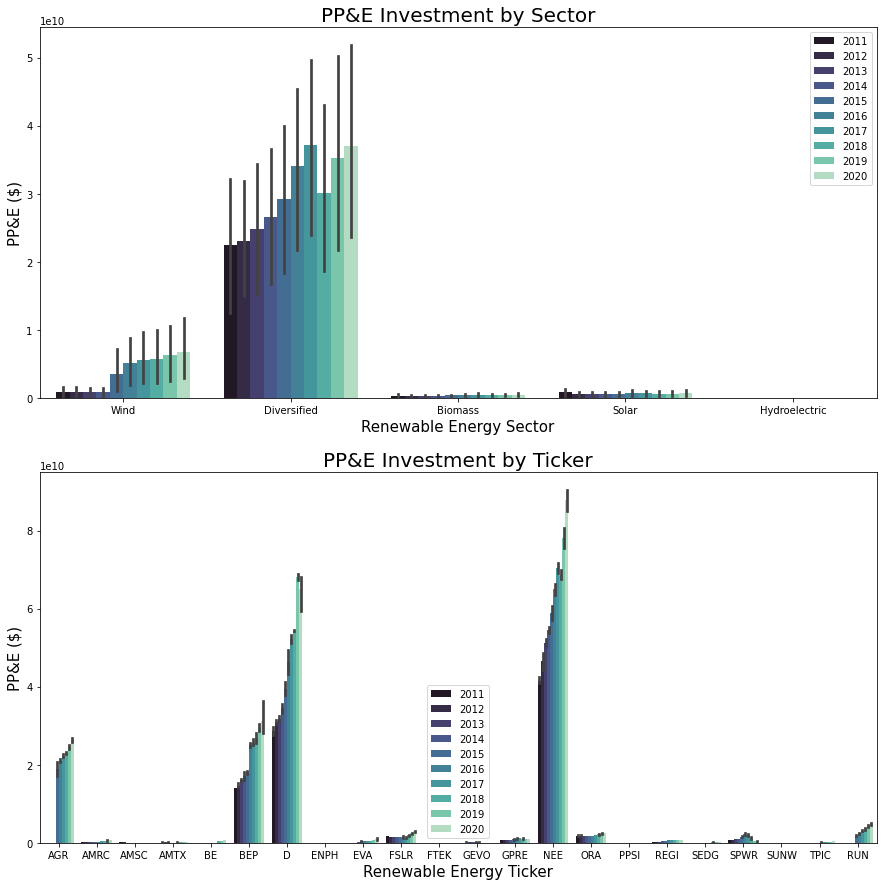

In [ ]:
plt.figure(figsize=(15,15))

#'cashAndEquivalents', 'shareholdersEquity'
ax1 = plt.subplot(211)
sns.barplot(data=master_cols, x="Sector", y="propertyPlantEquipmentNet", hue = "Year", palette = "mako")
plt.title('PP&E Investment by Sector', fontsize = 20)
plt.xlabel('Renewable Energy Sector', fontsize = 15)
plt.ylabel('PP&E ($)', fontsize = 15)
plt.legend(loc = "best")
#plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/ppe_sectors.png')

ax2 = plt.subplot(212)
sns.barplot(data=master_cols, x="Ticker", y="propertyPlantEquipmentNet", hue = "Year", palette = "mako")
plt.title('PP&E Investment by Ticker', fontsize = 20)
plt.xlabel('Renewable Energy Ticker', fontsize = 15)
plt.ylabel('PP&E ($)', fontsize = 15)
plt.legend(loc = "best")
#plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/ppe_tickers.png');

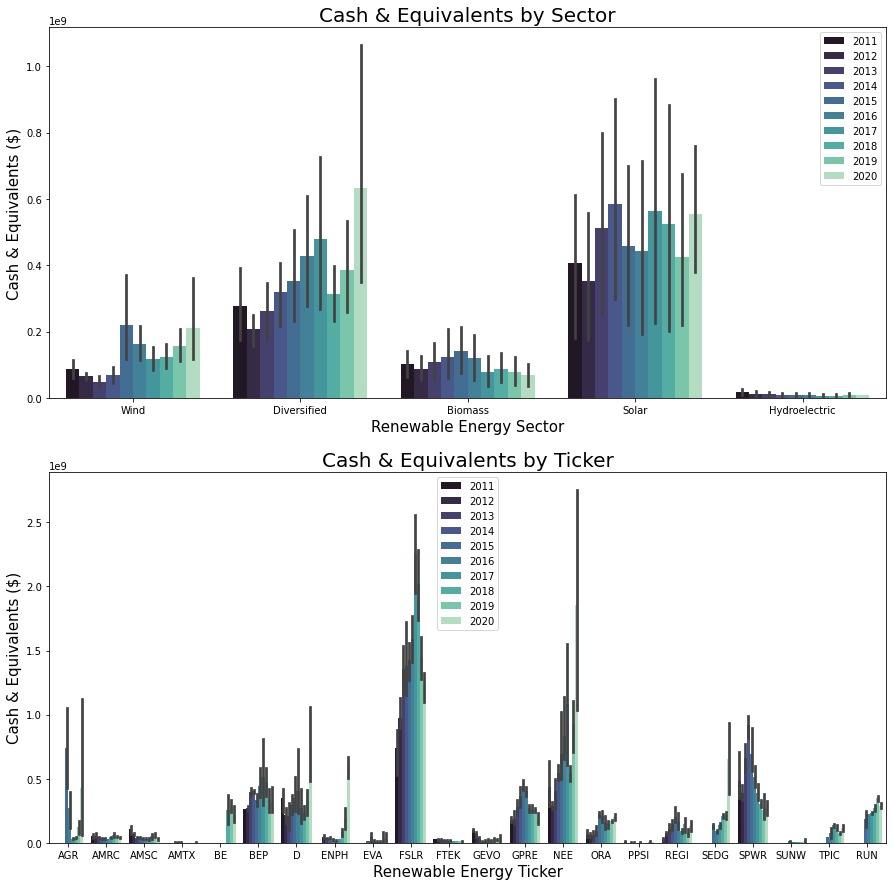

In [ ]:
plt.figure(figsize=(15,15))

#, 'shareholdersEquity'
ax1 = plt.subplot(211)
sns.barplot(data=master_cols, x="Sector", y="cashAndEquivalents", hue = "Year", palette = "mako")
plt.title('Cash & Equivalents by Sector', fontsize = 20)
plt.xlabel('Renewable Energy Sector', fontsize = 15)
plt.ylabel('Cash & Equivalents ($)', fontsize = 15)
plt.legend(loc = "best")
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/cash_sectors.png')

ax2 = plt.subplot(212)
sns.barplot(data=master_cols, x="Ticker", y='cashAndEquivalents', hue = "Year", palette = "mako")
plt.title('Cash & Equivalents by Ticker', fontsize = 20)
plt.xlabel('Renewable Energy Ticker', fontsize = 15)
plt.ylabel('Cash & Equivalents ($)', fontsize = 15)
plt.legend(loc = "best")
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/cash_tickers.png');

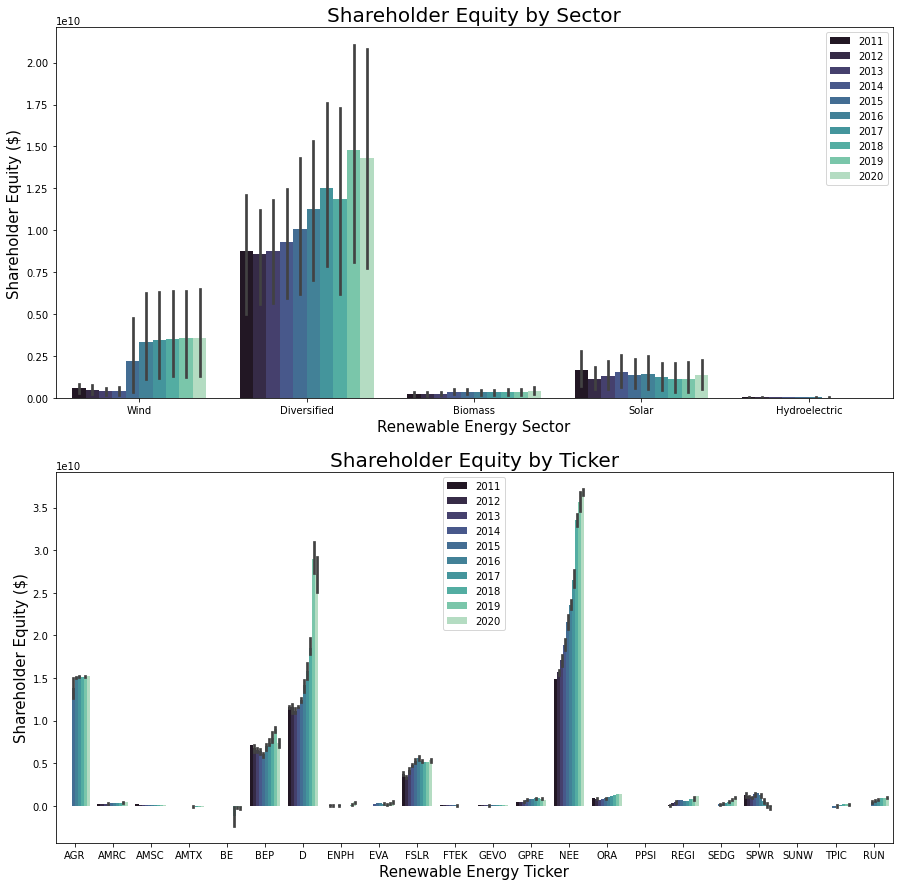

In [ ]:
plt.figure(figsize=(15,15))

#, 'shareholdersEquity'
ax1 = plt.subplot(211)
sns.barplot(data=master_cols, x="Sector", y='shareholdersEquity', hue = "Year", palette = "mako")
plt.title('Shareholder Equity by Sector', fontsize = 20)
plt.xlabel('Renewable Energy Sector', fontsize = 15)
plt.ylabel('Shareholder Equity ($)', fontsize = 15)
plt.legend(loc = "best")
#plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/sh_equity_sectors.png')

ax2 = plt.subplot(212)
sns.barplot(data=master_cols, x="Ticker", y='shareholdersEquity', hue = "Year", palette = "mako")
plt.title('Shareholder Equity by Ticker', fontsize = 20)
plt.xlabel('Renewable Energy Ticker', fontsize = 15)
plt.ylabel('Shareholder Equity ($)', fontsize = 15)
plt.legend(loc = "best")
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/sh_equity_tickers.png');

* Assessing EIA electricity generation data to ascertain 'electricity market share' for renewable sectors
  * Longer-term trends in electricity generation output may not serve as a viable predictor for momentum-trading volume, given the gradual trends observed in the EIA data versus the fairly volatile trading data captured throughout

No handles with labels found to put in legend.
No handles with labels found to put in legend.


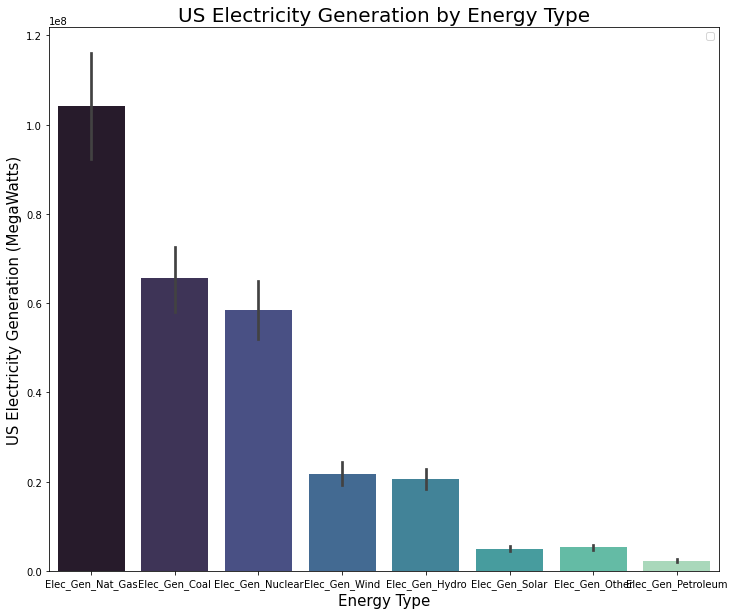

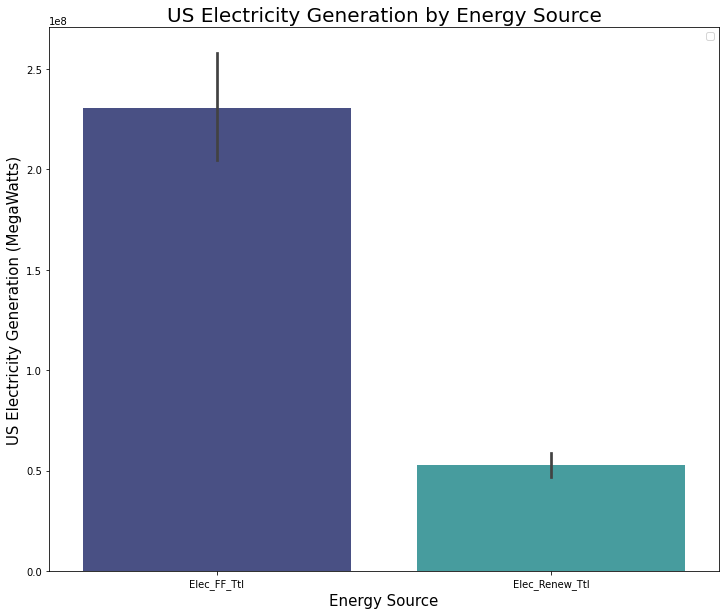

In [ ]:
## ELECTRICITY GENERATION - ENERGY TYPE
plt.figure(figsize=(12,10))
sns.barplot(data=master_cols, palette = "mako", order = ['Elec_Gen_Nat_Gas', 'Elec_Gen_Coal', 'Elec_Gen_Nuclear', 
       'Elec_Gen_Wind', 'Elec_Gen_Hydro', 'Elec_Gen_Solar', 'Elec_Gen_Other', 'Elec_Gen_Petroleum'])
plt.title('US Electricity Generation by Energy Type', fontsize = 20)
plt.xlabel('Energy Type', fontsize = 15)
plt.ylabel('US Electricity Generation (MegaWatts)', fontsize = 15)
plt.xticks()
plt.legend(loc = "best")
#plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/elec_gen_sector.png')

plt.figure(figsize=(12,10))
sns.barplot(data=master_cols, palette = "mako", order = ['Elec_FF_Ttl', 'Elec_Renew_Ttl'])
plt.title('US Electricity Generation by Energy Source', fontsize = 20)
plt.xlabel('Energy Source', fontsize = 15)
plt.ylabel('US Electricity Generation (MegaWatts)', fontsize = 15)
plt.legend(loc = "best")
#plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/elec_gen_source.png');

* Generating Heatmap Correlation charts to hone in on feature extraction for model pre-processing 
  * Quarterly and Trailing Volume metrics display similar variables of higher correlation; not entirely surprising, though there still appear a handful of slight differences between the two for financial balance sheet items and EIA variables 

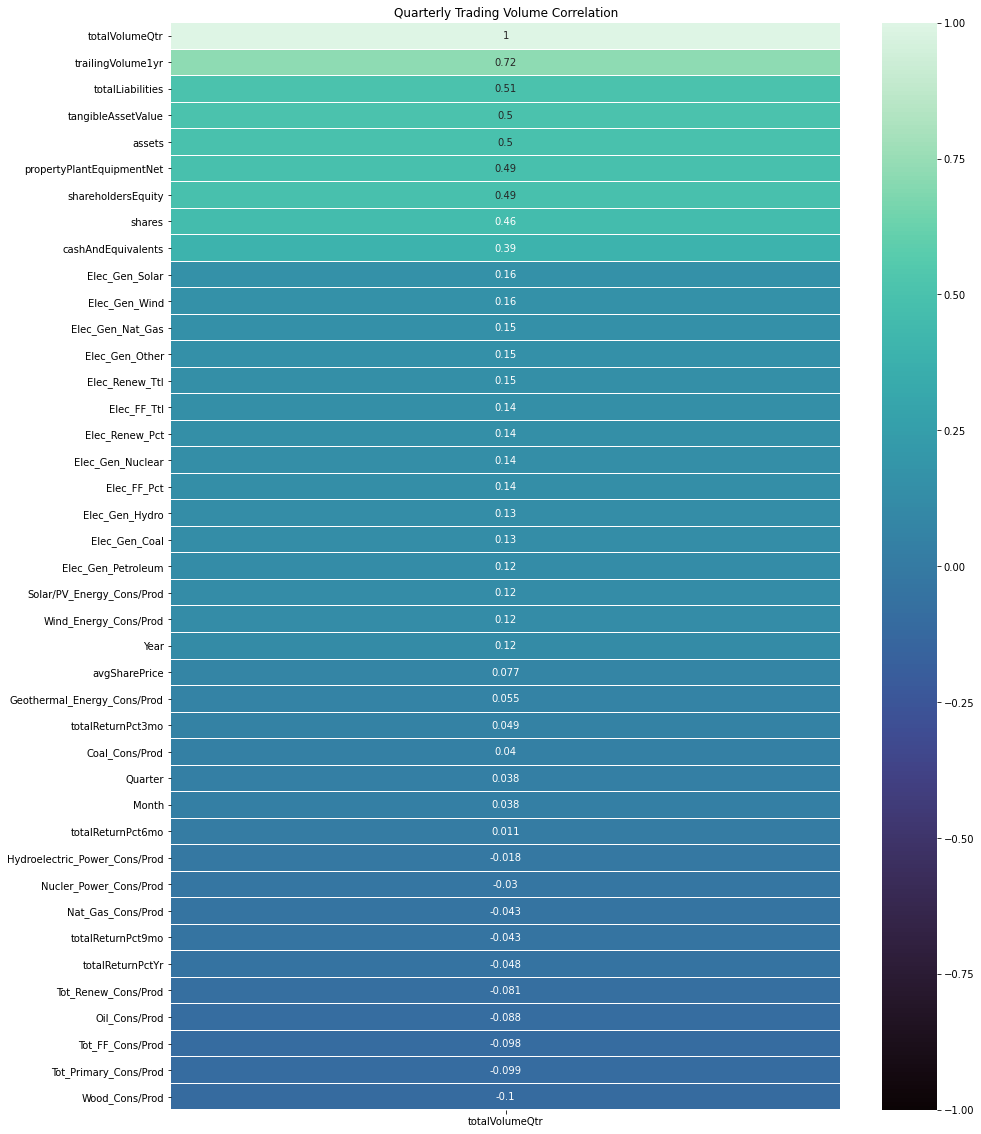

In [ ]:
# create correlation variable relative to rest of DataFrame
plt.figure(figsize=(15,20))
volume_qtr_corr = master_cols.corr()[['totalVolumeQtr']].sort_values(by = 'totalVolumeQtr', ascending = False)

# create heatmap to visualize correlation variable
sns.heatmap(volume_qtr_corr, annot = True, cmap = 'mako', vmin=-1, vmax=1, linecolor = 'white', linewidth = .015)
plt.title('Quarterly Trading Volume Correlation')
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/vol_qtr_corr.png');

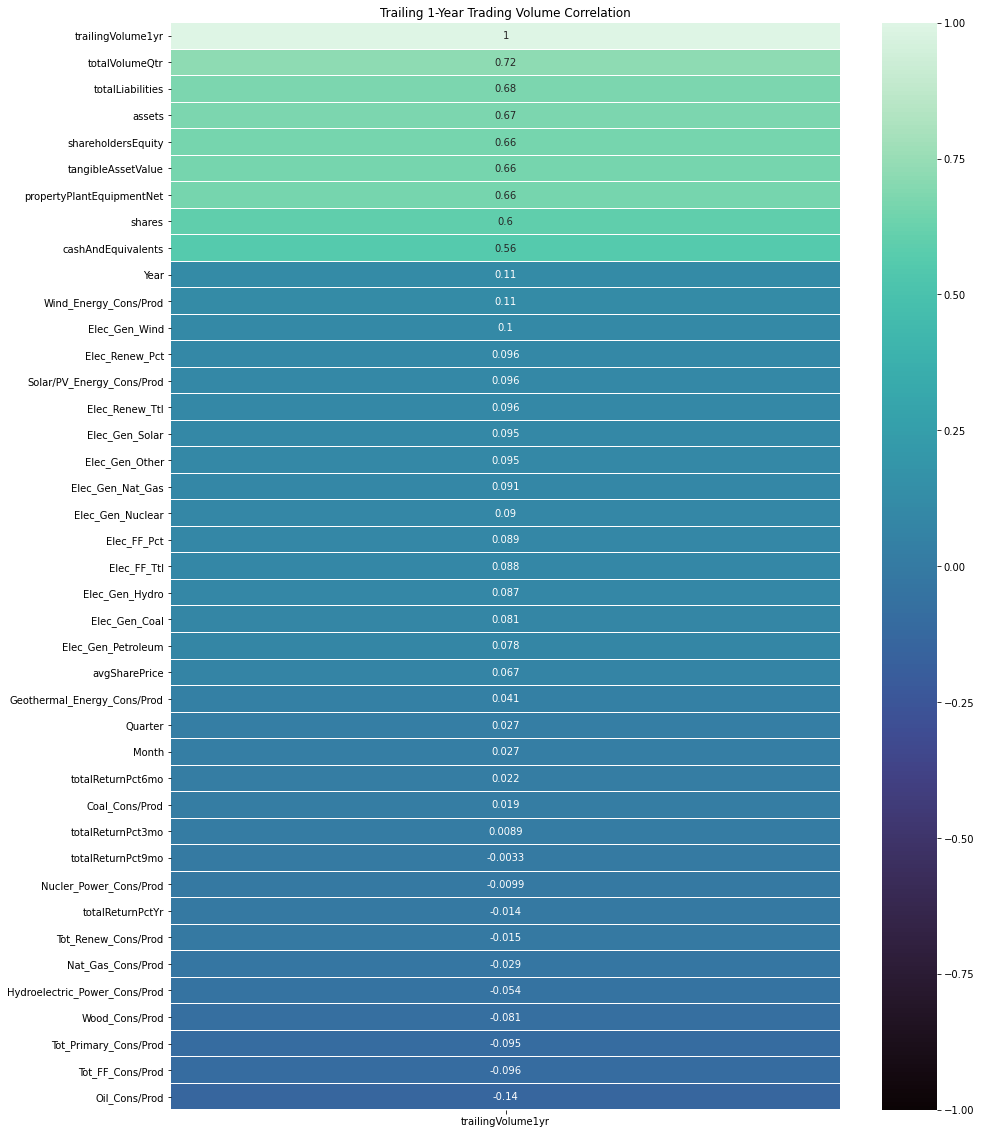

In [ ]:
# create correlation variable relative to rest of DataFrame
volume_1yr_corr = master_cols.corr()[['trailingVolume1yr']].sort_values(by = 'trailingVolume1yr', ascending = False)
# create heatmap to visualize correlation variable
plt.figure(figsize=(15,20))

# create heatmap to visualize correlation variable

sns.heatmap(volume_1yr_corr, annot = True, cmap = 'mako', vmin=-1, vmax=1, linecolor = 'white', linewidth = .015)
plt.title('Trailing 1-Year Trading Volume Correlation')
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/vol_1yr_corr.png');

* Briefly assessing institutional shareholders data to examine whether any funds or banks have taken outsized positions in renewable sectors / tickers of interest
  * Studying institutional ownership helps to pin down certain stocks with lower public floats, yet more extreme trading volume, which may be manipulated more easily by retail investors without the presense of big capital.

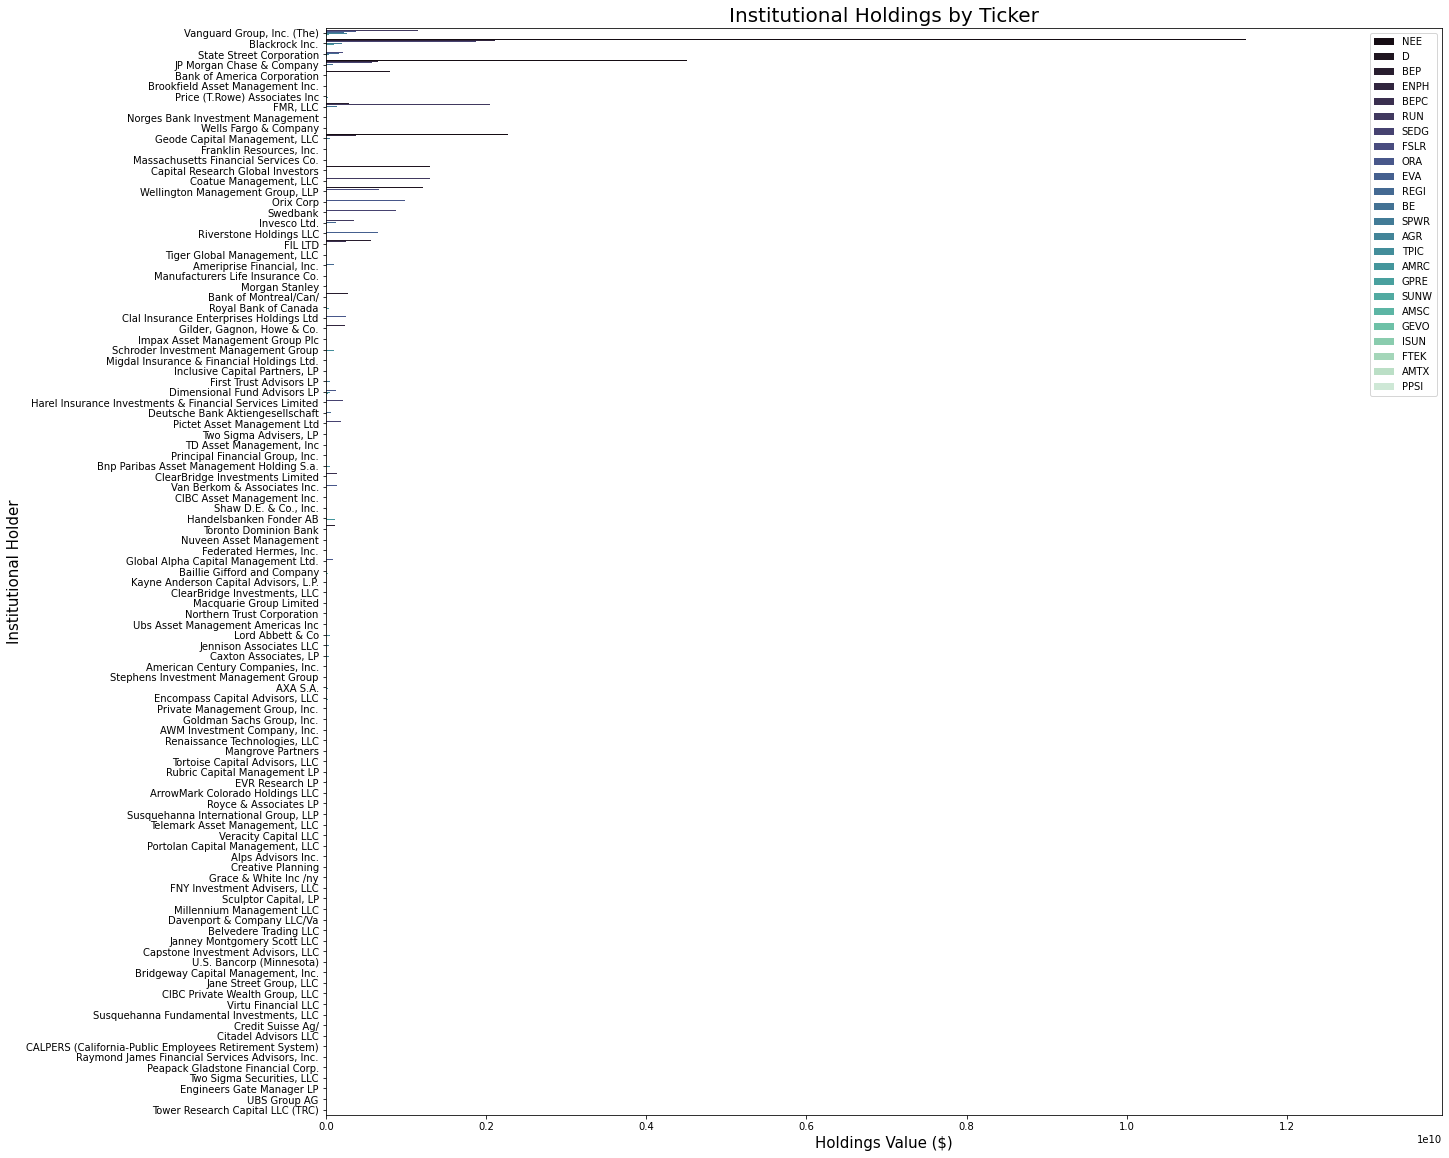

In [ ]:
plt.figure(figsize=(20,20))

holders_data = holders_data.sort_values(by = "Value", ascending = False)
sns.barplot(data=holders_data, x='Value', y='Holder', hue = holders_data.index, palette = "mako", linewidth = 2)
plt.title('Institutional Holdings by Ticker', fontsize = 20)
plt.xlabel('Holdings Value ($)', fontsize = 15)
plt.ylabel('Institutional Holder', fontsize = 15)
plt.legend(loc = "best")
plt.savefig('/drive/My Drive/Colab Notebooks/project05_data/images/holders_data.png')